In [1]:
from pylab import *
%matplotlib inline

In [2]:
import numpy as np
import random

In [3]:
import data

/home/alex/anaconda3/lib/python3.6/site-packages/dicom/__init__.py:53: UserWarning: 
This code is using an older version of pydicom, which is no longer 
maintained as of Jan 2017.  You can access the new pydicom features and API 
by installing `pydicom` from PyPI.
See 'Transitioning to pydicom 1.x' section at pydicom.readthedocs.org 
for more information.

  warnings.warn(msg)


In [4]:
df_nodes = data.luna16_get_df_nodes() 

In [5]:
df_nodes = df_nodes[(df_nodes["diameter_mm"]>6)]

In [6]:
patient_ids = data.luna16_get_patient_ids()

In [7]:
vsize = np.asarray([32,32,32])

In [8]:
def get_all_nodules():
    X = []
    diams = []
    for idx in range(len(df_nodes)):
        #print(idx)
        pid = df_nodes.iloc[idx]["pid"]
        image = data.luna16_get_image(pid)
        segmented_image = data.luna16_get_segmented_image(pid)
        info = data.luna16_get_info(pid)
        volume = data.luna16_get_node_volume(image, vsize, info, df_nodes, idx)
        X.append(volume.copy())
        diams.append(df_nodes.iloc[idx]["diameter_mm"])
    return X, diams

In [9]:
X_nodules, diams = get_all_nodules()

In [10]:
import scipy.ndimage.filters

In [11]:
def compose_make_mask(vsize, diam, sigma):
    grid = np.indices(vsize).astype(np.float32)
    grid = grid - vsize[:,None,None,None]/2.0
    mask = np.sqrt(np.sum(np.square(grid), axis=0)) < diam/2
                    
    mask = scipy.ndimage.filters.gaussian_filter(mask.astype(np.float32), sigma=sigma)
    return mask


In [12]:
def make_augmented(volume):
    idx = random.choice(range(len(X_nodules)))
    nodule = X_nodules[idx]
    # randomly flip or not flip each axis
    if random.choice([True, False]):
        nodule = nodule[::-1,:,:]
    if random.choice([True, False]):
        nodule = nodule[:,::-1,:]
    if random.choice([True, False]):
        nodule = nodule[:,:,::-1]
    mask = compose_make_mask(vsize, diam=diams[idx]+6, sigma=(diams[idx]+6)/8)
    volume_aug = data.compose_max2(volume, nodule, mask)
    return volume_aug

In [ ]:
X_backgrounds_lung = []
X_backgrounds_tissue = []
X_backgrounds_any = []
X_augmented_nodules = []

central_mask = compose_make_mask(vsize, diam=6+6, sigma=(6+6)/8)

n = 0
while True:
    if n % 100 == 0:
        try:
            pid = random.choice(patient_ids)
            image = data.luna16_get_image(pid)
            segmented_image = data.luna16_get_segmented_image(pid)
            info = data.luna16_get_info(pid)
        except Exception as e:
            print(pid, repr(e))
            continue

    n+=1
            
    pos = np.asarray([ np.random.randint(k, image.shape[k] - vsize[k]) for k in range(3) ])
    volume = image[pos[0]:pos[0]+vsize[0], pos[1]:pos[1]+vsize[1], pos[2]:pos[2]+vsize[2]]
    segmented_volume = segmented_image[pos[0]:pos[0]+vsize[0], pos[1]:pos[1]+vsize[1], pos[2]:pos[2]+vsize[2]]
    overlap = np.mean(segmented_volume)
    density = np.mean(volume)
    central_density = np.sum(np.mean((volume+1000)) * central_mask) / np.sum(central_mask) - 1000
    
    print(overlap, density, central_density)
    
    
    if len(X_backgrounds_any) < 100:
        X_backgrounds_any.append(volume.copy())
        continue
        
    if density > -320 and len(X_backgrounds_tissue) < 100:
        X_backgrounds_tissue.append(volume.copy())
        continue
        
    if overlap > 0 and len(X_backgrounds_lung) < 100:
        X_backgrounds_lung.append(volume.copy())
        
    if central_density < -320 and len(X_augmented_nodules) < 100:
        volume_aug = make_augmented(volume)
        X_augmented_nodules.append(volume_aug.copy())

0.2655029296875 -201.64056396484375 -201.64056396484375
0.219451904296875 -182.81692504882812 -182.81695556640625
0.08526611328125 -135.13592529296875 -135.135986328125
0.558685302734375 -537.6380310058594 -537.6380310058594
0.003692626953125 -121.82687377929688 -121.82696533203125
0.0 -997.3903198242188 -997.3903198242188
0.16162109375 -213.51263427734375 -213.51263427734375
0.0 -988.7987060546875 -988.7987060546875
0.19012451171875 -83.47531127929688 -83.475341796875
0.3204345703125 -345.41510009765625 -345.41510009765625
0.788482666015625 -705.2586975097656 -705.2586975097656
0.11273193359375 -184.30474853515625 -184.3046875
0.3045654296875 -361.95465087890625 -361.95465087890625
0.0 44.911712646484375 44.9117431640625
0.18756103515625 -199.44937133789062 -199.44927978515625
0.15155029296875 -61.67279052734375 -61.67279052734375
0.0 -14.639678955078125 -14.6396484375
0.0 -996.1320495605469 -996.1320495605469
0.2138671875 -215.70950317382812 -215.70941162109375
0.0 -999.335693359375 

In [ ]:
len(X_background_lung)

In [8]:
def get_backgrounds(num_samples=10):
#     mask = compose_make_mask(vsize, diam=6, sigma=1)
    X = []
    while len(X) < num_samples:
        try:
            pid = random.choice(patient_ids)
            image = data.luna16_get_image(pid)
            segmented_image = data.luna16_get_segmented_image(pid)
            info = data.luna16_get_info(pid)
            volume, segmented_volume, overlap = data.luna16_get_volume(image, segmented_image, vsize, min_overlap=0.5)
            if volume is None:
                continue
#             density = np.sum( (volume+1000)*mask ) / np.sum(mask) - 1000
#             if density < -600:
#                 continue
            X.append(volume.copy())
        except Exception as e:
            print(repr(e))
    return X

In [59]:
num_samples = 10000
X_backgrounds = get_backgrounds(num_samples=num_samples)

ValueError('mmap length is greater than file size',)
ValueError('mmap length is greater than file size',)
FileNotFoundError(2, 'No such file or directory')
ValueError('mmap length is greater than file size',)
ValueError('mmap length is greater than file size',)
ValueError('mmap length is greater than file size',)
ValueError('mmap length is greater than file size',)
ValueError('mmap length is greater than file size',)
ValueError('mmap length is greater than file size',)
ValueError('mmap length is greater than file size',)
ValueError('mmap length is greater than file size',)
ValueError('mmap length is greater than file size',)
ValueError('mmap length is greater than file size',)
ValueError('mmap length is greater than file size',)
ValueError('mmap length is greater than file size',)
ValueError('mmap length is greater than file size',)
ValueError('mmap length is greater than file size',)
ValueError('mmap length is greater than file size',)
ValueError('mmap length is greater than file size

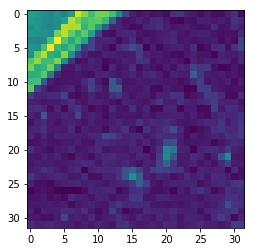

In [62]:
imshow(X_backgrounds[9999][16])

In [83]:
X_augmented_nodules = []
num_samples = 10000
while len(X_augmented_nodules) < num_samples:
    try:
        k = len(X_augmented_nodules)
        idx = random.choice(range(len(X_nodules)))
        nodule = X_nodules[idx]
        # randomly flip or not flip each axis
        if random.choice([True, False]):
            nodule = nodule[::-1,:,:]
        if random.choice([True, False]):
            nodule = nodule[:,::-1,:]
        if random.choice([True, False]):
            nodule = nodule[:,:,::-1]
        mask = compose_make_mask(vsize, diam=diams[idx]+6, sigma=(diams[idx]+6)/8)
        volume_aug = data.compose_max2(X_backgrounds[k], nodule, mask)
        X_augmented_nodules.append(volume_aug)
    except Exception as e:
        print(repr(e))

ValueError('operands could not be broadcast together with shapes (32,32,31) (32,32,32) ',)
ValueError('operands could not be broadcast together with shapes (32,32,31) (32,32,32) ',)
ValueError('operands could not be broadcast together with shapes (32,32,0) (32,32,32) ',)
ValueError('operands could not be broadcast together with shapes (32,32,31) (32,32,32) ',)
ValueError('operands could not be broadcast together with shapes (32,32,31) (32,32,32) ',)
ValueError('operands could not be broadcast together with shapes (32,32,0) (32,32,32) ',)
ValueError('operands could not be broadcast together with shapes (32,32,0) (32,32,32) ',)
ValueError('operands could not be broadcast together with shapes (32,32,0) (32,32,32) ',)
ValueError('operands could not be broadcast together with shapes (32,32,0) (32,32,32) ',)
ValueError('operands could not be broadcast together with shapes (32,32,31) (32,32,32) ',)
ValueError('operands could not be broadcast together with shapes (32,32,31) (32,32,32) ',)
Valu

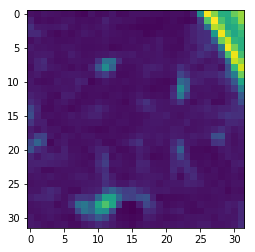

In [91]:
imshow(X_backgrounds[10][16])

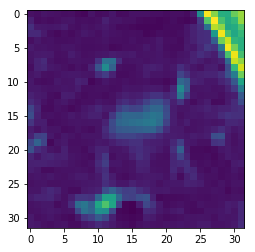

In [90]:
imshow(X_augmented_nodules[10][16])

In [88]:
X = np.stack(X_backgrounds + X_augmented_nodules).astype(np.int16)

In [89]:
np.save("/mnt/data/luna16/sets/toy_set_v1_20k.npy", X[:,:,:,:,None])